In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# testing file
# file = xr.open_dataset('/Users/victoriaford/Downloads/ASOSAWOS_72053900165.nc')
file = xr.open_dataset('/Users/victoriaford/Desktop/Train_Files/CAHYDRO_BROC1.nc') # has flagged vars

df = file.to_dataframe()

In [5]:
df = df.reset_index() 
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable

In [6]:
df

,station,time,tas,pr,tas_qc,elevation,lat,lon,month,year
0,CAHYDRO_BROC1,2010-05-30 15:30:00,300.940,NaN,nan,549.8592,33.2314,-116.4144,5,2010
1,CAHYDRO_BROC1,2010-05-31 15:20:00,301.490,NaN,nan,549.8592,33.2314,-116.4144,5,2010
2,CAHYDRO_BROC1,2010-06-05 15:20:00,303.160,NaN,nan,549.8592,33.2314,-116.4144,6,2010
3,CAHYDRO_BROC1,2010-06-06 15:25:00,304.830,NaN,nan,549.8592,33.2314,-116.4144,6,2010
4,CAHYDRO_BROC1,2010-06-12 15:25:00,294.830,NaN,nan,549.8592,33.2314,-116.4144,6,2010
...,...,...,...,...,...,...,...,...,...,...
2968,CAHYDRO_BROC1,2022-07-31 23:50:00,311.494,NaN,nan,549.8592,33.2314,-116.4144,7,2022
2969,CAHYDRO_BROC1,2022-08-06 23:20:00,315.383,NaN,nan,549.8592,33.2314,-116.4144,8,2022
2970,CAHYDRO_BROC1,2022-08-08 00:40:00,312.050,NaN,nan,549.8592,33.2314,-116.4144,8,2022
2971,CAHYDRO_BROC1,2022-08-21 00:20:00,310.939,NaN,nan,549.8592,33.2314,-116.4144,8,2022


In [7]:
def _plot_format_helper(var):
    """
    Helper function for plots 
    """
    
    if var == 'tas':
        ylab = 'Air Temperature at 2m'
        unit = 'K'
#         ylim = (240, 320)
        
    elif var == 'tdps' or var == 'tdps_derived':
        ylab = 'Dewpoint Temperature'
        unit = 'K'
#         ylim = (230, 300)
        
    elif var == 'sfcWind':
        ylab = 'Surface Wind Speed'
        unit = 'm s-1'
#         ylim = (0, 30)
        
    elif var == 'sfcWind_dir':
        ylab = 'Surface Wind Direction'
        unit = 'degrees'
#         ylim = (0, 360)
        
    elif var == 'rsds':
        ylab = 'Surface Radiation'
        unit = 'W m-2'
#         ylim = (0, 1500)
        
    elif var == 'pr':
        ylab = 'Precipitation'
        unit = 'mm'
#         ylim = (0, 2000)
        
    return (ylab, unit)
    

In [8]:
def _plot_flagged_months(df, var):
    """
    Helper function to plot flagged months in the monthly distributional checks functions
    Currently set-up for monthly gap check.
    Produces a timeseries figure
    """
    
    labels = _plot_format_helper(var=var)
    
    # testing
    flagged_plot = df.plot.scatter(x='time',
                                   y=var,
                                   ylabel=labels[0] + ' ({})'.format(labels[1]),
                                   figsize=(9,3),
                                   s=1,
#                                    ylim=labels[2],
                                   color='k',
                                   label='Testing');
    
#     ax = df_good.plot.scatter(x='time', y=var, figsize=(9,2), s=1, color='k', label='Pass') 
#     df_bad.plot.scatter(x='time', y=var, figsize=(9,2), s=1, color='r', label='Flagged', ax=ax) 

    
    return flagged_plot

<Axes: xlabel='time', ylabel='Air Temperature at 2m (K)'>

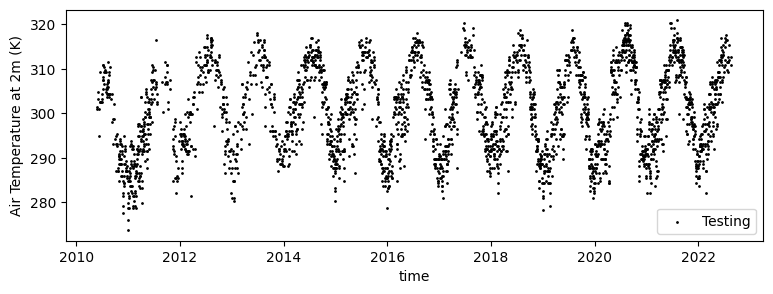

In [9]:
_plot_flagged_months(df, var='tas')

---
part 2 test


In [ ]:
## part2 

# compare all observations in a single month, all years
# histogram created from all obs and gaussian distribution is fitted
# threshold values are determined using positions where fitted frequency falls below y=0.1
# and rounding outwards to the next integer plus one
# going outwards from center, distribution is scanned for gaps which occur outside threshold value
# obs beyond gap are flagged


## gaussian distribution may not be a perfect fit for bulk of obs, with thresholds too high
## allow for non-zero skew and kurtosis by using gauss-hermite series
## updated thresholds occur closer to bulk of distribution curve

#--------------------------------------------------------------------------------------
# intention is to have a function like: 

# def qaqc_dist_gaps_check(df, plot=False):
#     if plot=True:
#         plot_gap_check(df, var) # etc. 

In [10]:
def create_bins(data, bin_size=0.25):
    '''Create bins from data covering entire data range'''

    # set up bins
    b_min = np.floor(np.nanmin(data))
    b_max = np.ceil(np.nanmax(data))
    bins = np.arange(b_min - bin_size, b_max + (3. * bin_size), bin_size)

    return bins

In [11]:
def iqr_standardize(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    
    return (df[var].values - df[var].median()) / iqr

In [12]:
def plot_gap_check(df, var):
    
    # standardize against IQR range
    df_month_iqr = iqr_standardize(df, var)
    
    # determine number of bins
    bins = create_bins(df_month_iqr)
    
    # plot histogram
    plt.hist(df_month_iqr, bins=bins, log=False, density=True, alpha=0.3);
    xmin, xmax = plt.xlim()
    plt.ylim(ymin=0.1)

    # plot pdf
    mu = np.nanmean(df_month_iqr)
    sigma = np.nanstd(df_month_iqr)
    y = stats.norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'k--', linewidth=1)
    
    # add vertical lines to indicate thresholds where pdf y=0.1
    pdf_bounds = np.argwhere(y > 0.1)

    # find first index
    left_bnd = round(bins[pdf_bounds[0][0] -1])
    right_bnd = round(bins[pdf_bounds[-1][0] + 1])
    thresholds = (left_bnd - 1, right_bnd + 1)

    plt.axvline(thresholds[1], color='r') # left tail
    plt.axvline(thresholds[0], color='r') # right tail
    
#     plt.gca().set_yscale('log')

    # flag (visually) obs that are beyond threshold
    # bar_value_to_label = -2.25
    # patch_index = np.digitize([bar_value_to_label], x)[0]
    # hh.patches[patch_index].set_color('r')
    # hh.patches[patch_index].set_alpha(1)

    # title and useful annotations
    plt.title('Distribution gap check, {0}: {1}'.format(df['station'].unique()[0], var), fontsize=10);
    plt.annotate('Month: {}'.format(m), xy=(0.025, 0.95), xycoords='axes fraction', fontsize=8);
    plt.annotate('Mean: {}'.format(round(mu,3)), xy=(0.025, 0.9), xycoords='axes fraction', fontsize=8);
    plt.annotate('Std.Dev: {}'.format(round(sigma,3)), xy=(0.025, 0.85), xycoords='axes fraction', fontsize=8);
    plt.ylabel('Frequency (obs)')
    
    
    # put AWS save figure stuffs here
    
    return

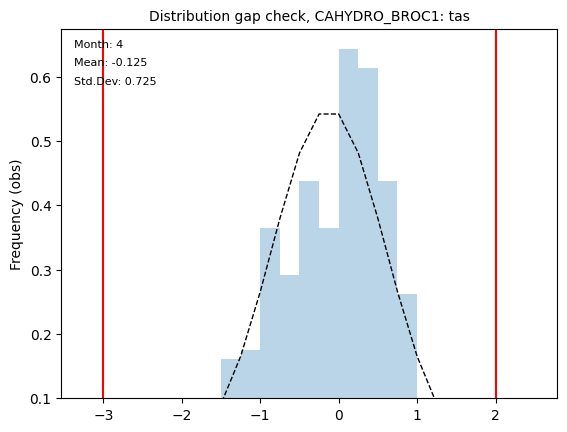

In [17]:
m = 4
df_month = df.loc[df['month'] == m]

plot_gap_check(df_month, var='tas')

In [ ]:
def qaqc_dist_gaps_part2(df, plot=True):
    """
    Part 2 / monthly check
        - compare all obs in a single month, all years
        - histogram created from all obs and gaussian distribution fitted
        - threshold values determined using positions where fitted freq falls below y=0.1
        - rounds outwards to next integer plus one
        - going outwards from center, distribution is scanned for gaps which occur outside threshold
        - obs beyond gap are flagged
    Goal: identifies individual suspect observations and flags the entire month  
    """
    
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc', 'duration', 'method', 'lat', 'lon', 'elevation', 'time', 'month', 'year'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
    
    # run through each month
    for m in range(1):
        df_month = df.loc[df['month'] == m+1]

        plot_gap_check(df_month, var='tas')
        
        
    
#     return df
    